# 01. Levenshtein Distance for Biomechanics Metadata (hands-on with mockup data)

- **Our objective**: Learn how to quantify the "distance" between inconsistent naming conventions in sensor data to automate dataset harmonization.

- **What is Levenshtein Distance anyway?**
The Levenshtein distance is a string metric for measuring the difference between two sequences. Informally, it is the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one word into the other.

- **Why this matters for us**: In biomechanics, one lab might name a sensor ```L_Ankle``` while another uses ```LeftAnkle```. Manual mapping is prone to error and slow. By calculating the Normalized Similarity, we can:
    - Automatically suggest matches between different datasets
    - Flag sensors that are too "distant" from our Master Schema (potential hardware mismatches)
    - Validate that our harmonization pipeline actually reduced the structural distance to zero

- This is just a very beginning of measuring the difference between datasets, as the core part would be the **coordinate system difference**, sampling rate, etc.

### 00. Environment Setup
- Before running the Levenshtein analysis, we need to ensure the environment is configured with the correct libraries.
- Make sure this notebook and the `environment.yml` file are in the same directory.

In [2]:
!conda env create -f environment.yml

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.2
  latest version: 26.1.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=26.1.0



packaging-26.0       | 70 KB     |                                       |   0% 
libblas-3.11.0       | 18 KB     |                                       |   0% 

libbrotlicommon-1.2. | 78 KB     |                                       |   0% 


brotli-bin-1.2.0     | 18 KB     |                                       |   0% 



xorg-libxau-1.0.12   | 14 KB     |                                       |   0% 




statsmodels-0.14.5   | 9.9 MB    |                                       |   0% 





xorg-libxdmcp-1.1.5  | 19 KB     |                                       |   0% 






llvm-openmp-21.1.8   | 279 KB    |                                       |   0% 







libtiff-4.

- Run below line by line, in your terminal (ignore [DEBUG] lines; they're just warnings not errors)

In [ ]:
!conda install ipykernel -y

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): conda.anaconda.org:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
- DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/noarch/current_repodata.json HTTP/11" 200 None
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/noarch/current_repodata.json HTTP/11" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/osx-arm64/current_repodata.json HTTP/11" 200 None
\ DEBUG:urllib3.connectionpool:https://conda.anaconda.org:443 "GET /conda-forge/noarch/current_repodata.json HTTP/11" 200 None
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/osx-a

In [5]:
!python -m ipykernel install --user --name harmonize --display-name "Python (Harmonize)"

Installed kernelspec harmonize in /Users/nny/Library/Jupyter/kernels/harmonize


> **[NOTE]** After running the line above, remember to go to the "Kernel" menu in your Jupyter notebook and select "Select Another Kernel.." → "Python Environments.." → "Python (Harmonize)".

### 01. Implementation of a very basic function
- We don't just compare raw strings. We first strip "syntactic noise" (underscores, spaces, case sensitivity) to focus on the semantic content. (
    
    e.g., `'accel_X'` = `'accelX'`, `'accel_X '`, `'accel_x'`; 
    
    I set it like this as these noise are easily corrected with a line of code in Python. But this is just my idea and we can measure more strictly (
        
    e.g., `'accel_X'` != `'accelX'`).
    )

In [1]:
import numpy as np
import pandas as pd
import Levenshtein
import matplotlib.pyplot as plt
import seaborn as sns

# Professional logging colors
BLUE, GREEN, YELLOW, RED, RESET = '\033[94m', '\033[92m', '\033[93m', '\033[91m', '\033[0m'

def get_similarity(s1, s2):
    """
    Calculates normalized Levenshtein similarity [0 to 1].
    1.0 = Perfect match
    0.0 = Entirely different
    """
    # Pre-processing: Remove "noise" that doesn't change the anatomical meaning
    n1 = s1.lower().replace("_", "").replace("-", "").replace(" ", "")
    n2 = s2.lower().replace("_", "").replace("-", "").replace(" ", "")
    
    # Calculate raw distance (number of edits)
    dist = Levenshtein.distance(n1, n2)
    
    # Normalize by the length of the longest string
    max_len = max(len(n1), len(n2), 1)
    return 1 - (dist / max_len)

# Example: Visualize the difference
word_a = "L_Thigh"
word_b = "Left_Thigh"
sim = get_similarity(word_a, word_b)
print(f"{BLUE}Similarity between '{word_a}' and '{word_b}': {sim:.2f}{RESET}")

Similarity between 'L_Thigh' and 'Left_Thigh': 0.67


### 02. Comparing Biomechanics Conventions
- We define four datasets representing common real-world scenarios: Standard, Abbreviated, Verbose, and our final Harmonized output.

In [16]:
# Dataset 1: Standard/Local CMU Convention (The "Master Schema")
d1_sensors = ["L_Ankle", "R_Ankle", "L_Shank", "R_Shank", "L_Thigh", "R_Thigh", "Pelvis"]
d1_channels = ["accel_x", "accel_y", "accel_z", "gyro_x", "gyro_y", "gyro_z"]

# Dataset 2: Abbreviated/Noisy (e.g., from a mobile app export)
d2_sensors = ["lankle", "rankle", "lshank", "rshank", "lthigh", "rthigh", "pelvis"]
d2_channels = ["Acc-X", "Acc-Y", "Acc-Z", "Gyr-X", "Gyr-Y", "Gyr-Z"]

# Dataset 3: Descriptive/Verbose (e.g., from a clinical partner)
d3_sensors = ["Left_Ankle", "Right_Ankle", "Left_Shank", "Right_Shank", "Left_Thigh", "Right_Thigh", "Sacrum"]
d3_channels = ["acceleration_x", "acceleration_y", "acceleration_z", "angular_vel_x", "angular_vel_y", "angular_vel_z"]

# Dataset 4: Our Pipeline's (Hypothetical) Harmonized Output
d4_sensors = d1_sensors.copy()
d4_channels = d1_channels.copy()

def compare_metadata(set_a_sensors, set_a_cols, set_b_sensors, set_b_cols, label):
    print(f"\n{BLUE}--- Evaluating Distance: {label} ---{RESET}")
    
    # Calculate Mean Sensor Site Similarity
    s_sims = [get_similarity(a, b) for a, b in zip(set_a_sensors, set_b_sensors)]
    # Calculate Mean Channel Name Similarity
    c_sims = [get_similarity(a, b) for a, b in zip(set_a_cols, set_b_cols)]
    
    avg_sim = (np.mean(s_sims) + np.mean(c_sims)) / 2
    distance = 1 - avg_sim
    
    print(f"  Sensor Site Match: {np.mean(s_sims):.2f}")
    print(f"  Channel Name Match: {np.mean(c_sims):.2f}")
    print(f"  {YELLOW}Structural Distance: {distance:.4f}{RESET}")
    return distance

# Compute distances relative to the Master Schema
dist_1_2 = compare_metadata(d1_sensors, d1_channels, d2_sensors, d2_channels, "D1 (Standard) vs D2")
dist_1_3 = compare_metadata(d1_sensors, d1_channels, d3_sensors, d3_channels, "D1 (Standard) vs D3")


--- Evaluating Distance: D1 (Standard) vs D2 ---
  Sensor Site Match: 1.00
  Channel Name Match: 0.73
  Structural Distance: 0.1333

--- Evaluating Distance: D1 (Standard) vs D3 ---
  Sensor Site Match: 0.54
  Channel Name Match: 0.37
  Structural Distance: 0.5450


### 03. Visualizing the Distance Matrix

[INFO] Running point-to-point similarity validation...


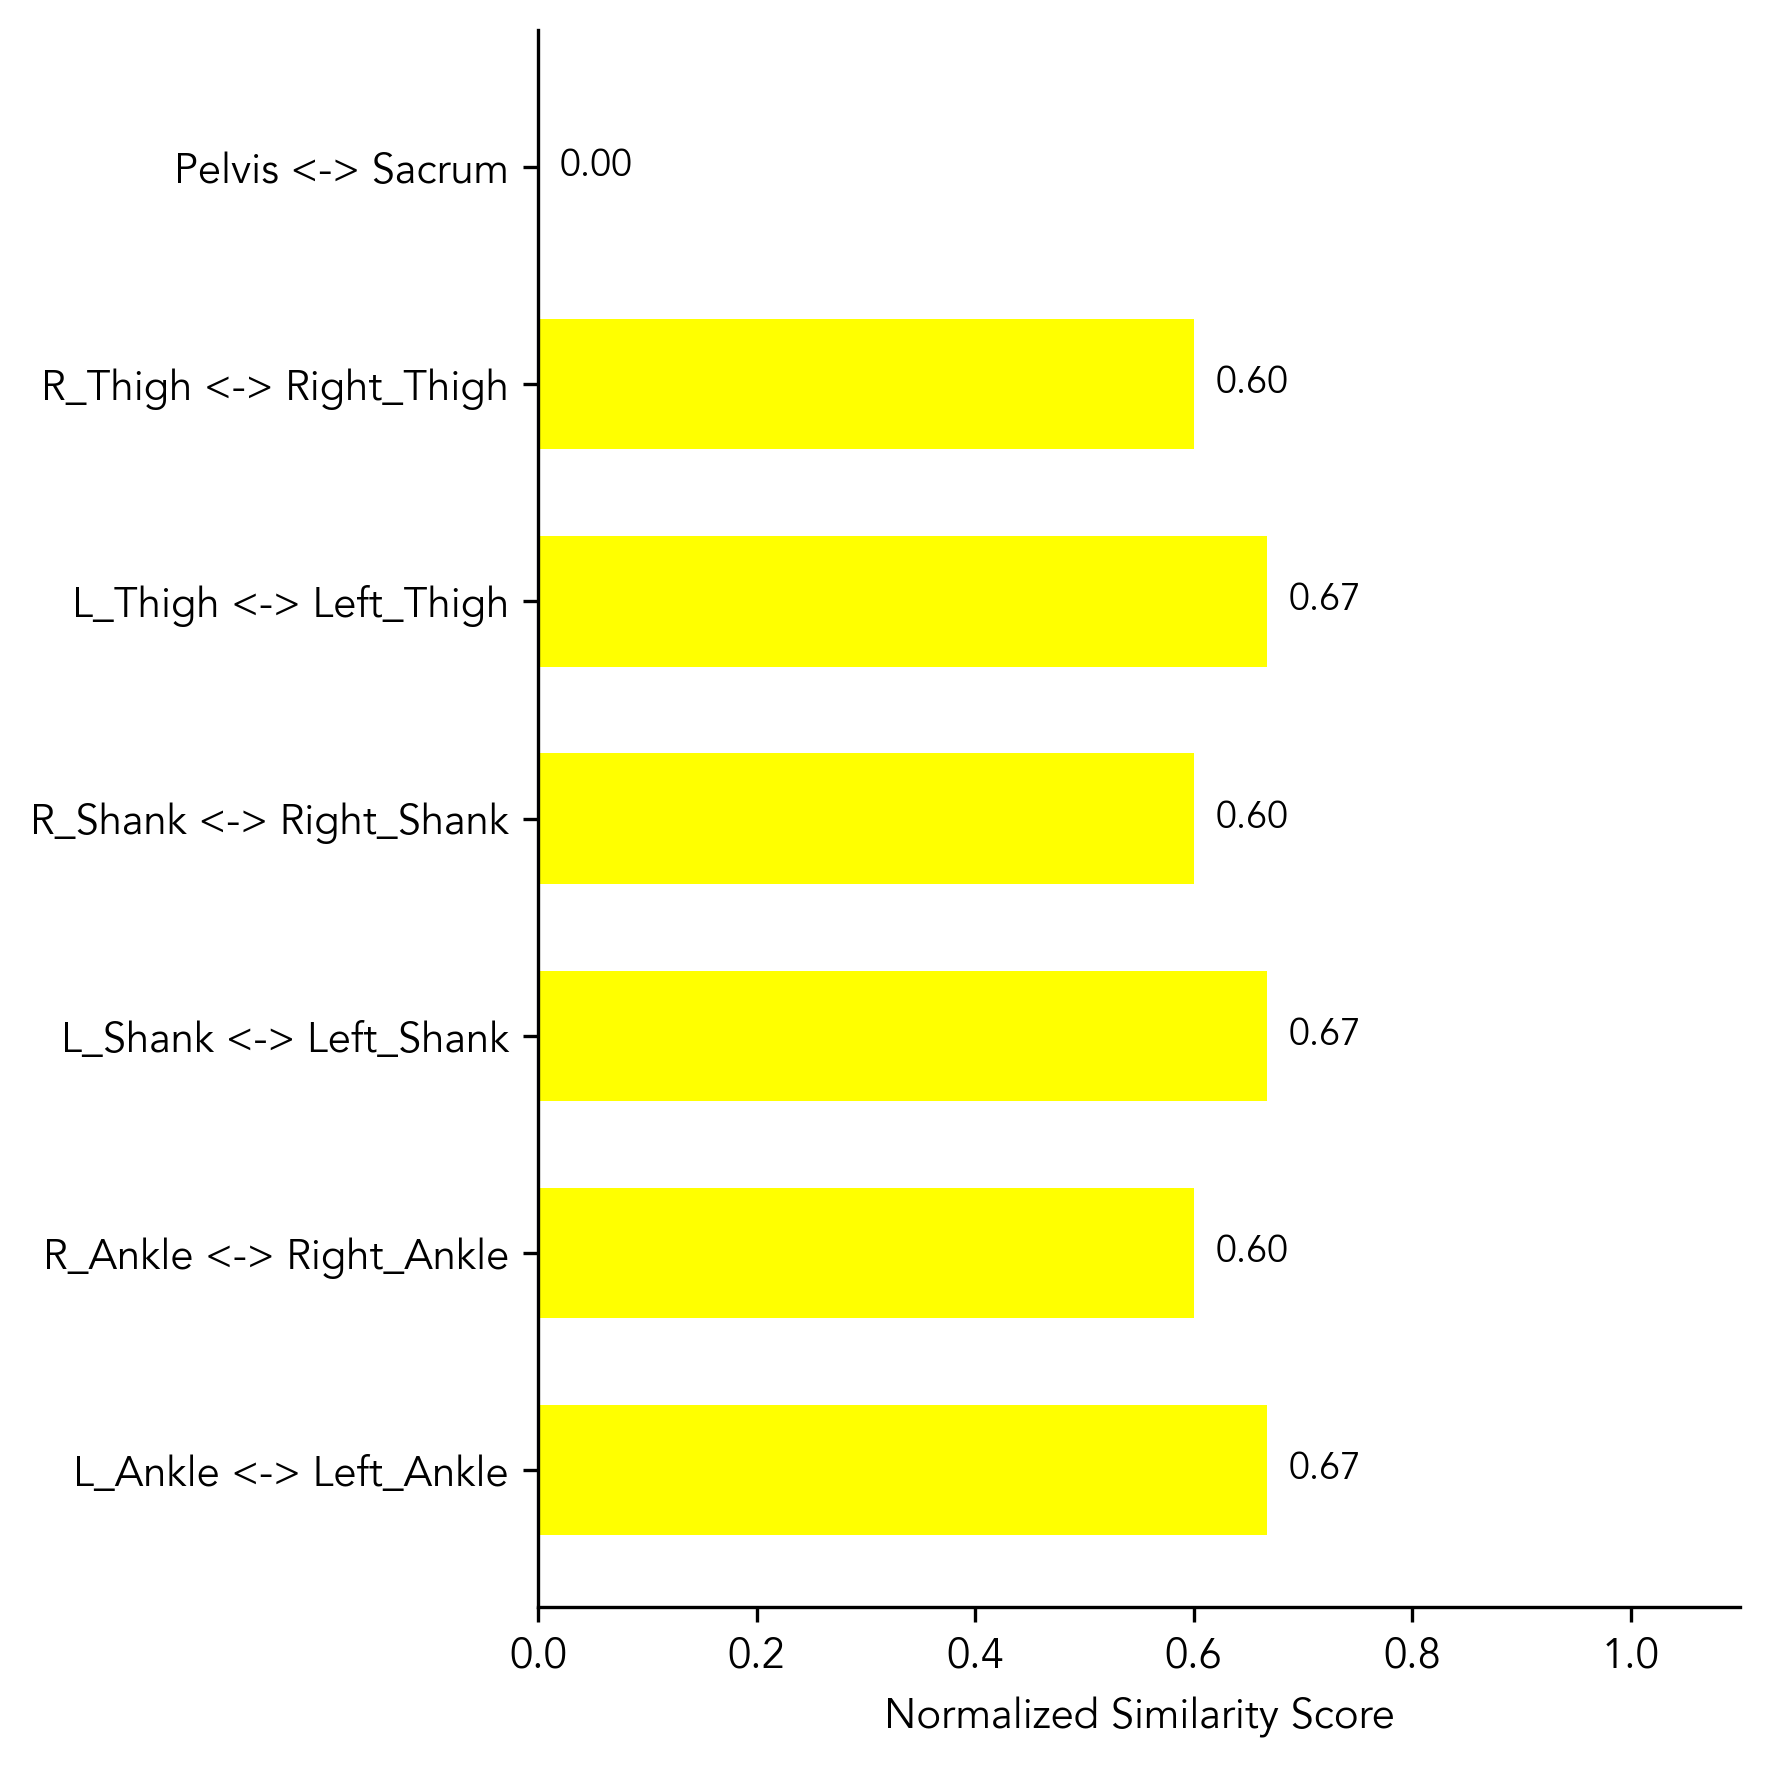

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Apply Maxwell Standards (Avenir, 300 DPI, No Spines)
plt.rcParams.update({
    'font.family': 'Avenir',
    'figure.dpi': 300,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

def plot_structural_integrity(master_list, test_list, label="D1 vs D3"):
    # Calculate one-to-one similarity
    similarities = [get_similarity(m, t) for m, t in zip(master_list, test_list)]
    
    # Setup Plot
    fig, ax = plt.subplots(figsize=(6, 6)) # 1:1 Ratio
    colors = [f"green" if s > 0.8 else f"yellow" if s > 0.5 else f"red" for s in similarities]
    
    y_pos = np.arange(len(master_list))
    ax.barh(y_pos, similarities, color=colors, height=0.6)
    
    # Formatting
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{m} <-> {t}" for m, t in zip(master_list, test_list)], family='Avenir')
    ax.set_xlabel("Normalized Similarity Score", family='Avenir')
    ax.set_xlim(0, 1.1)
    
    # Add value labels
    for i, s in enumerate(similarities):
        ax.text(s + 0.02, i, f"{s:.2f}", va='center', family='Avenir', fontsize=9)

    plt.tight_layout()
    plt.show()

# Run the diagnostic
print(f"{BLUE}[INFO]{RESET} Running point-to-point similarity validation...")
plot_structural_integrity(d1_sensors, d3_sensors, "Standard vs Verbose Sensors")

- From here, we learn that `Sacrum` needs a manual standardization.

### 04. Final Validation
- Let's say that we standardized all column names.. A successful harmonization should bring the structural distance to 0 (zero).

In [6]:
# Final Analysis
mean_dist = (dist_1_2 + dist_1_3) / 2
print(f"\n{GREEN}===========================================")
print(f"TOTAL COHORT PRE-HARMONIZATION DISTANCE: {mean_dist:.4f}")
print(f"Cohort Overlap: {(1-mean_dist)*100:.1f}%")
print(f"==========================================={RESET}")

print(f"\n{RED}POST-HARMONIZATION CHECK: Standard vs. Harmonized{RESET}")
dist_1_4 = compare_metadata(d1_sensors, d1_channels, d4_sensors, d4_channels, "D1 (Standard) vs D4 (Harmonized)")

if dist_1_4 == 0:
    print(f"\n{GREEN}SUCCESS: Pipeline achieved zero structural distance.{RESET}")
else:
    print(f"\n{RED}FAILURE: Residual distance of {dist_1_4:.4f} detected.{RESET}")


TOTAL COHORT PRE-HARMONIZATION DISTANCE: 0.3392
Cohort Overlap: 66.1%

POST-HARMONIZATION CHECK: Standard vs. Harmonized

--- Evaluating Distance: D1 (Standard) vs D4 (Harmonized) ---
  Sensor Site Match: 1.00
  Channel Name Match: 1.00
  Structural Distance: 0.0000

SUCCESS: Pipeline achieved zero structural distance.


# 02. Levenshtein Distance for Biomechanics Metadata (hands-on with real-world data)
- We will use HuGaDB and YARETA Dataset

In [20]:
hugadb_path = "dataset/hugadb/HuGaDB_v2_various_01_00.csv" # a sample subject
yareta_path = "dataset/yareta/Human gait and other movements - markers inertial sensors pressure insoles force plates/researchdata/P01_S01/SYNC_DATA/P01_S01_SlowGait_01.csv"

In [21]:
# load data
hugadb_df = pd.read_csv(hugadb_path)
yareta_df = pd.read_csv(yareta_path)

# check shapes
print(f"HuGaDB Shape: {hugadb_df.shape}")
print(f"YARETA Shape: {yareta_df.shape}")

HuGaDB Shape: (2435, 40)
YARETA Shape: (571, 279)


In [22]:
# print the columns
print("\nHuGaDB Columns:")
print(hugadb_df.columns.tolist())
print("\nYARETA Columns:")
print(yareta_df.columns.tolist())


HuGaDB Columns:
['Unnamed: 0', 'accelerometer_right_foot_x', 'accelerometer_right_foot_y', 'accelerometer_right_foot_z', 'gyroscope_right_foot_x', 'gyroscope_right_foot_y', 'gyroscope_right_foot_z', 'accelerometer_right_shin_x', 'accelerometer_right_shin_y', 'accelerometer_right_shin_z', 'gyroscope_right_shin_x', 'gyroscope_right_shin_y', 'gyroscope_right_shin_z', 'accelerometer_right_thigh_x', 'accelerometer_right_thigh_y', 'accelerometer_right_thigh_z', 'gyroscope_right_thigh_x', 'gyroscope_right_thigh_y', 'gyroscope_right_thigh_z', 'accelerometer_left_foot_x', 'accelerometer_left_foot_y', 'accelerometer_left_foot_z', 'gyroscope_left_foot_x', 'gyroscope_left_foot_y', 'gyroscope_left_foot_z', 'accelerometer_left_shin_x', 'accelerometer_left_shin_y', 'accelerometer_left_shin_z', 'gyroscope_left_shin_x', 'gyroscope_left_shin_y', 'gyroscope_left_shin_z', 'accelerometer_left_thigh_x', 'accelerometer_left_thigh_y', 'accelerometer_left_thigh_z', 'gyroscope_left_thigh_x', 'gyroscope_left_th

In [23]:
# the sensor columns are the ones starts with 'P6'
yareta_imu_cols = [col for col in yareta_df.columns if col.startswith('P6')]
print("\nYARETA IMU Columns:")
print(yareta_imu_cols)


YARETA IMU Columns:
['P6_LF_acc_x', 'P6_LF_acc_y', 'P6_LF_acc_z', 'P6_LS_acc_x', 'P6_LS_acc_y', 'P6_LS_acc_z', 'P6_LT_acc_x', 'P6_LT_acc_y', 'P6_LT_acc_z', 'P6_RF_acc_x', 'P6_RF_acc_y', 'P6_RF_acc_z', 'P6_RS_acc_x', 'P6_RS_acc_y', 'P6_RS_acc_z', 'P6_RT_acc_x', 'P6_RT_acc_y', 'P6_RT_acc_z', 'P6_SA_acc_x', 'P6_SA_acc_y', 'P6_SA_acc_z', 'P6_TR_acc_x', 'P6_TR_acc_y', 'P6_TR_acc_z', 'P6_LF_gyro_x', 'P6_LF_gyro_y', 'P6_LF_gyro_z', 'P6_LS_gyro_x', 'P6_LS_gyro_y', 'P6_LS_gyro_z', 'P6_LT_gyro_x', 'P6_LT_gyro_y', 'P6_LT_gyro_z', 'P6_RF_gyro_x', 'P6_RF_gyro_y', 'P6_RF_gyro_z', 'P6_RS_gyro_x', 'P6_RS_gyro_y', 'P6_RS_gyro_z', 'P6_RT_gyro_x', 'P6_RT_gyro_y', 'P6_RT_gyro_z', 'P6_SA_gyro_x', 'P6_SA_gyro_y', 'P6_SA_gyro_z', 'P6_TR_gyro_x', 'P6_TR_gyro_y', 'P6_TR_gyro_z']


In [27]:
# assuming LF: left foot, LS: left shank, LT: left thigh, RF: right foot, RS: right shank, RT: right thigh, SA: pelvis
yareta_imu_cols_feet = [col for col in yareta_imu_cols if any(part in col for part in ['F'])]
print("\nYARETA IMU Columns - Feet:")
print(yareta_imu_cols_feet)


YARETA IMU Columns - Feet:
['P6_LF_acc_x', 'P6_LF_acc_y', 'P6_LF_acc_z', 'P6_RF_acc_x', 'P6_RF_acc_y', 'P6_RF_acc_z', 'P6_LF_gyro_x', 'P6_LF_gyro_y', 'P6_LF_gyro_z', 'P6_RF_gyro_x', 'P6_RF_gyro_y', 'P6_RF_gyro_z']


In [28]:
yareta_imu_cols_feet_sensor_names = [col.split('_')[1] for col in yareta_imu_cols_feet]
print("\nYARETA IMU Columns - Feet Sensor Names:")
print(pd.Series(yareta_imu_cols_feet_sensor_names).unique())
yareta_imu_cols_feet_channel_names = [col.split('_')[2] + col.split('_')[3] for col in yareta_imu_cols_feet]
print("\nYARETA IMU Columns - Feet Channel Names:")
print(pd.Series(yareta_imu_cols_feet_channel_names).unique())


YARETA IMU Columns - Feet Sensor Names:
['LF' 'RF']

YARETA IMU Columns - Feet Channel Names:
['accx' 'accy' 'accz' 'gyrox' 'gyroy' 'gyroz']


In [33]:
hugadb_cols_feet = [col for col in hugadb_df.columns if any(part in col.lower() for part in ['foot'])]
print("\nHuGaDB Feet Sensor Columns:")
print(hugadb_cols_feet)


HuGaDB Feet Sensor Columns:
['accelerometer_right_foot_x', 'accelerometer_right_foot_y', 'accelerometer_right_foot_z', 'gyroscope_right_foot_x', 'gyroscope_right_foot_y', 'gyroscope_right_foot_z', 'accelerometer_left_foot_x', 'accelerometer_left_foot_y', 'accelerometer_left_foot_z', 'gyroscope_left_foot_x', 'gyroscope_left_foot_y', 'gyroscope_left_foot_z']


In [40]:

hugadb_cols_feet_sensor_names = [col.split('_')[1] + col.split('_')[2] for col in hugadb_cols_feet]
print("\nHuGaDB Feet Channel Names:")
print(pd.Series(hugadb_cols_feet_sensor_names).unique())
hugadb_cols_feet_channel_names = [col.split('_')[0] + col.split('_')[-1] for col in hugadb_cols_feet]
print("\nHuGaDB Feet Sensor Names:")
print(pd.Series(hugadb_cols_feet_channel_names).unique())


HuGaDB Feet Channel Names:
['rightfoot' 'leftfoot']

HuGaDB Feet Sensor Names:
['accelerometerx' 'accelerometery' 'accelerometerz' 'gyroscopex'
 'gyroscopey' 'gyroscopez']


- Results:

YARETA IMU Columns - Feet Sensor Names:
['LF' 'RF']

YARETA IMU Columns - Feet Channel Names:
['accx' 'accy' 'accz' 'gyrox' 'gyroy' 'gyroz']


HuGaDB Feet Channel Names:
['rightfoot' 'leftfoot']

HuGaDB Feet Sensor Names:
['accelerometerx' 'accelerometery' 'accelerometerz' 'gyroscopex'
 'gyroscopey' 'gyroscopez']

In [45]:
# harmonize 
GT_SENSOR_NAMES = ['lfoot', 'rfoot']

GT_CHANNEL_NAMES = [
    "xacc", "yacc", "zacc", "xgyr", "ygyr", "zgyr"
]

In [46]:
dist_yareta = compare_metadata(GT_SENSOR_NAMES, GT_CHANNEL_NAMES, yareta_imu_cols_feet_sensor_names, yareta_imu_cols_feet_channel_names, "GT Feet vs YARETA Feet")
dist_hugadb = compare_metadata(GT_SENSOR_NAMES, GT_CHANNEL_NAMES, hugadb_cols_feet_sensor_names, hugadb_cols_feet_channel_names, "GT Feet vs HuGaDB Feet")


--- Evaluating Distance: GT Feet vs YARETA Feet ---
  Sensor Site Match: 0.30
  Channel Name Match: 0.25
  Structural Distance: 0.7250

--- Evaluating Distance: GT Feet vs HuGaDB Feet ---
  Sensor Site Match: 0.50
  Channel Name Match: 0.17
  Structural Distance: 0.6643


In [ ]:
# alter sensor names to master sensor names
yareta_imu_cols_feet_sensor_names_new = ["lfoot", "rfoot"]
hugadb_cols_feet_sensor_names_new = ["lfoot", "rfoot"]
yareta_imu_cols_feet_channel_names_new = ["xacc", "yacc", "zacc", "xgyr", "ygyr", "zgyr"]
hugadb_cols_feet_channel_names_new = ["xacc", "yacc", "zacc", "xgyr", "ygyr", "zgyr"]

In [48]:
# get the new dist
dist_yareta_new = compare_metadata(GT_SENSOR_NAMES, GT_CHANNEL_NAMES, yareta_imu_cols_feet_sensor_names_new, yareta_imu_cols_feet_channel_names_new, "GT Feet vs YARETA Feet (Harmonized)")
dist_hugadb_new = compare_metadata(GT_SENSOR_NAMES, GT_CHANNEL_NAMES, hugadb_cols_feet_sensor_names_new, hugadb_cols_feet_channel_names_new, "GT Feet vs HuGaDB Feet (Harmonized)")


--- Evaluating Distance: GT Feet vs YARETA Feet (Harmonized) ---
  Sensor Site Match: 0.17
  Channel Name Match: 1.00
  Structural Distance: 0.4167

--- Evaluating Distance: GT Feet vs HuGaDB Feet (Harmonized) ---
  Sensor Site Match: 0.17
  Channel Name Match: 1.00
  Structural Distance: 0.4167
